In [2]:
import numpy as np

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
base_Edu=pd.read_parquet("D:\\2AD ENSAE\\Projet de statistique appliquée\\Dossier travail\\base_Edu.parquet")
base_Edu

,unique_learner_id,days_between_signup_and_first_activity,days_between_order_and_first_activity,first_theory_activity_date,days_between_first_and_last_activities,chapter_before_success_count,serie_before_success_count,quiz_before_success_count,theory_activities_total,weekly_study_objective,...,nb_weeks_weekly_study_objective_reached_80pct,nb_weeks_weekly_study_objective_reached_75pct,nb_weeks_weekly_study_objective_reached_70pct,nb_weeks_weekly_study_objective_not_reached,nb_weeks_no_activity,nb_weeks_no_weekly_study_objective,pct_study_objective_reached,pct_study_objective_not_reached,pct_study_objective_no_activity,pct_no_objective_weeks
0,3838161406066513919,41,0,2017-12-17 15:00:23.000000,265,0,3,0,3,<NA>,...,0,0,0,0,0,1,0.0,0.0,0.0,100.0
1,5829430568065349352,0,0,2022-07-07 12:02:53.000000,27,0,0,0,11,<NA>,...,0,0,0,0,0,1,0.0,0.0,0.0,100.0
2,7677180318050051984,787,788,2022-05-10 01:35:49.000000,295,0,0,0,73,240,...,0,0,0,1,0,0,0.0,100.0,0.0,0.0
3,-5150597998144597550,615,616,2024-04-18 04:56:03.262330,138,0,0,0,75,<NA>,...,0,0,0,0,0,1,0.0,0.0,0.0,100.0
4,969323468959211246,169,170,2019-03-19 12:32:56.000000,554,0,0,0,41,120,...,0,0,0,1,0,0,0.0,100.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,1306435320134834461,0,-4,2021-02-25 10:11:13.000000,7,0,0,0,11,240,...,0,0,0,1,0,0,0.0,100.0,0.0,0.0
199996,5732789662758255879,0,0,2017-12-06 15:46:14.000000,45,0,0,0,7,<NA>,...,0,0,0,0,0,1,0.0,0.0,0.0,100.0
199997,3325713948509922176,17,9,2019-07-21 18:24:08.000000,229,0,0,0,83,<NA>,...,0,0,0,0,0,1,0.0,0.0,0.0,100.0
199998,7446387329160512320,68,57,2021-10-28 19:09:58.000000,172,0,242,0,310,120,...,0,0,0,15,0,0,0.0,100.0,0.0,0.0


In [4]:
print(base_Edu.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 477 entries, unique_learner_id to pct_no_objective_weeks
dtypes: Int64(72), boolean(254), datetime64[us](1), float64(150)
memory usage: 450.9 MB
None


La base de données compte donc 477 variables dont 72 de type Int, 254 de type boolean, 1 de type datetime et 150 de type float soit au total 254 variables qualitatives (**boolean**) et 221 variables quantitatives(**float + int** en excluant les identifiants) sans oublier la variable de type **datetime**.

Nous commencons par épurer la base données avant de passer à la réduction de dimension. On s'intéressera aux valeurs manquantes. 

In [5]:
missing_value=(base_Edu.isnull().sum()/len(base_Edu))
missing_value[missing_value>0]
missing_value[missing_value>0].describe()

count    404.000000
mean       0.743390
std        0.279055
min        0.047720
25%        0.666710
50%        0.842345
75%        0.918625
max        1.000000
dtype: float64

La base de données comporte donc 404 variables avec valeurs manquantes sur le total des 476 variables de la base ce qui n'est pas du tout négligeable. Voyons combien de valeurs manquantes at-on par type de variables. 

In [6]:
print(base_Edu.select_dtypes("int").isnull().any().sum()," variables de type int ont des valeurs manquantes")
print(base_Edu.select_dtypes("float").isnull().any().sum()," variables de type float ont des valeurs manquantes")
print(base_Edu.select_dtypes("boolean").isnull().any().sum()," variables de type boolean ont des valeurs manquantes")
print(base_Edu.select_dtypes("datetime").isnull().any().sum()," variables de type datetime ont des valeurs manquantes")

48  variables de type int ont des valeurs manquantes
103  variables de type float ont des valeurs manquantes
253  variables de type boolean ont des valeurs manquantes
0  variables de type datetime ont des valeurs manquantes


La seule variable de type datetime n'a donc pas de valeurs manquantes.  Analysons de plus près les proportions de valeurs manquantes des autres types

In [7]:
miss_bool=base_Edu.select_dtypes("boolean").isnull().sum()/len(base_Edu)
miss_bool[miss_bool>0].describe()

count    253.000000
mean       0.903116
std        0.072136
min        0.695085
25%        0.837765
50%        0.883305
75%        1.000000
max        1.000000
dtype: float64

Les variables de type boolean comporte pratiquement tous assez de valeurs manquantes avec un minimum de 69% et un maximum de 100% du total des observations

Les valeurs manquantes de la base ne sont pas complètement aléatoires. Elles ne sont pas pour la plupart le fruit d'une mauvaise collecte de données. La présence de valeurs manquantes dans cette base est due à diverses raisons notamment le fait que plusieurs individus de la base n'ont pas encore passé d'examen pour le permis. Plusieurs questions(variables) n'ont de sens que dans le cas où le premier examen est passé. Il y a donc une part d'information apporté par ces valeurs manquantes que nous devons inclure dans nos analyses. Pour les variables booléenne, nous pouvons régler ce prblème c'est à dire prendre en compte l'information apportée par ces valeurs manquantes en transformant les variables booléennes en variable catégorielles en considérant les valeurs manquantes comme une catégorie(True=1,False=0 et NA=2).

In [8]:
#print(base_Edu.select_dtypes('category'))
def encode_column_with_na(col):
    mapping = {True: 1, False: 0, pd.NA: 2}  # Encoder les valeurs booléennes et <NA>
    return col.map(mapping)
colboo=base_Edu.select_dtypes("boolean").columns
for col in colboo:
    base_Edu[col] = encode_column_with_na(base_Edu[col]).astype("category")
#base_Edu["is_first_exam_success"].cat.categories


Passons maintenant aux variables quantitatives (int+float)

In [9]:
miss_quant=base_Edu.select_dtypes(include=["int","float"]).isnull().sum()/len(base_Edu)
miss_quant[miss_quant>0].describe()

count    151.000000
mean       0.475770
std        0.292138
min        0.047720
25%        0.184915
50%        0.483995
75%        0.736010
max        0.941710
dtype: float64

Pour les variables quantitatives, la distribution des valeurs manquantes est plus étendue. On enregistre 151 variables quantitatives avec valeurs manquantes. On a un minimum de 4% et un maximum de 94% de valeurs manquantes par rapport au total d'observation(nous rappelons 200000 obervations). La nature des variables et la distribution des valeurs manquantes dans ce cas ne facilite pas la capture de l'information apportée par la présence de ces valeurs manquantes. On pourrait opter pour une imputation par KNN ou par imputation itérative (MICE) mais cela risque de modifier et significativement les corrélations existant déjà entre les variables introduisant ainsi un important biais et au vue de la taille de l'echantillon, cela demanderait un temps d'excution énorme. On choisit ici donc de procéder à une imputation par la médiane après suppression des variables avant un taux élevé de valeurs manquantes pour minimiser le biais. Cela permettra de ne pas trop distordre les distributions existentes.

In [10]:
miss_quant[miss_quant<=0.20].describe()

count    118.000000
mean       0.054362
std        0.074368
min        0.000000
25%        0.000000
50%        0.000000
75%        0.106310
max        0.194530
dtype: float64

Nous choisissons le seuil de 20% de valeurs manquantes. Ce seuil nous parait raisonnable puisqu'il est relativement faible et n'entraine pas la suppression d'un grand nombre de variables quantitatives (118 sont conservées sur un total de 151)

In [11]:
#suppression des variables avec plus de 20% de valeurs manquantes
base_Edu=base_Edu.drop(columns=miss_quant[miss_quant>0.20].index)
#Imputation par la médiane
col=base_Edu.select_dtypes(exclude='category').columns
base_Edu[col] = base_Edu[col].fillna(base_Edu[col].median())

In [12]:
base_Edu.isnull().any().sum()

0

Plus aucune valeur manquante. La base de données enfin prête, on peut passer aux opérations de réduction de dimension

## ACP

In [13]:
#base_acp=base_Edu.select_dtypes(include=["int","float"]).drop(columns="unique_learner_id")

In [14]:
#pip install ploty

In [15]:
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.decomposition import PCA
# import matplotlib.pyplot as plt
# from sklearn.preprocessing import StandardScaler
 
# # Étape 1 : Identifier les colonnes catégorielles
# #base_acp=base_Edu.select_dtypes('float').drop(columns="unique_learner_id")
# categorical_columns = base_acp.select_dtypes(include=['object', 'category']).columns
# numerical_columns = base_acp.select_dtypes(include=['int64', 'float64']).columns

# # Étape 2 : Encodage One-Hot des colonnes catégorielles
# encoder = OneHotEncoder(sparse_output=False)
# encoded_categorical = encoder.fit_transform(base_acp[categorical_columns])
# modalities = encoder.get_feature_names_out(categorical_columns)  # Noms des modalités encodées

# # Étape 3 : Combiner les colonnes numériques et encodées
# import numpy as np
# if numerical_columns.any():
#     combined_data = np.hstack((base_acp[numerical_columns].values, encoded_categorical))
# else:
#     combined_data = encoded_categorical

# #Centrer et réduire les variables 
# scaler=StandardScaler()
# base_acp=scaler.fit_transform(base_acp)

# # Étape 4 : Application de l'ACP
# pca = PCA(n_components=10)
# components = pca.fit_transform(combined_data)
 
# # Créer un DataFrame avec les trois premiers axes
# pca_df = pd.DataFrame(
#     components,
#     columns=['PCA1', 'PCA2', 'PCA3','PCA4','PCA5','PCA6','PCA7','PCA8','PCA9','PCA10']
# )

# # Étape 5 : Visualisation des composantes principales
# plt.figure(figsize=(8, 6))
# plt.scatter(components[:, 0], components[:, 1], s=100, alpha=0.7, c='blue')
# plt.title('Analyse en composantes principale (ACP)')
# plt.xlabel('Composante principale 1')
# plt.ylabel('Composante principale 2')
# plt.grid()
# plt.show()

# # Étape 6 : Variance expliquée par chaque composante
# print("Variance expliquée par chaque composante :", pca.explained_variance_ratio_)

In [16]:
# # Étape 3 : Récupérer la variance expliquée
# explained_variance = pca.explained_variance_ratio_

# # Afficher la variance expliquée par axe
# for i, var in enumerate(explained_variance, start=1):
#     print(f"Axe {i}: {var * 100:.2f}% de variance expliquée")


# import matplotlib.pyplot as plt

# # Graphique de la variance expliquée
# plt.figure(figsize=(8, 5))
# plt.bar(range(1, len(explained_variance) + 1), explained_variance * 100, color='blue', alpha=0.7)
# plt.title('Variance expliquée par axe')
# plt.xlabel('Axe')
# plt.ylabel('Variance expliquée (%)')
# plt.xticks(range(1, len(explained_variance) + 1))
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.show()

## FAMD

In [17]:
#!pip install prince

In [18]:
# base_Edu.info()
# base_Edu_sample = base_Edu.sample(n=5000, random_state=42)

In [19]:
# import pandas as pd
# from prince import FAMD


# # Identifier les types de colonnes
# numeric_cols = base_Edu_sample.select_dtypes(include=['int64', 'float64']).columns
# categorical_cols = base_Edu_sample.select_dtypes(include=['category', 'object', 'bool']).columns

# # Note : Les colonnes datetime64 ne sont pas directement utilisables dans la FAMD.
# # On pourrait les transformer si elles ont du sens (par exemple en extraire l'année, le mois, etc.)
# datetime_cols = base_Edu_sample.select_dtypes(include=['datetime64']).columns
# #une tab
# if len(datetime_cols) > 0:
#     print("Transformation des colonnes datetime")
#     for col in datetime_cols:
#         base_Edu_sample[col + '_year'] = base_Edu_sample[col].dt.year
#         base_Edu_sample[col + '_month'] = base_Edu_sample[col].dt.month
#         base_Edu_sample[col + '_day'] = base_Edu_sample[col].dt.day
#     base_Edu_sample = base_Edu_sample.drop(columns=datetime_cols)

# # Application de la FAMD
# famd = FAMD(n_components=378, random_state=42)  # Conserver 10 dimensions
# print("je suis là")
# base_Edu_reduced = famd.fit_transform(base_Edu_sample)
# print('jai fini')
# # Résultat : DataFrame réduit
# base_Edu_reduced = pd.DataFrame(base_Edu_reduced, columns=[f"FAMD_{i+1}" for i in range(base_Edu_reduced.shape[1])])

# # Afficher les premières lignes
# print(base_Edu_reduced.head())

## Auto-Encoder

Nous commencons d'abord par exclure les identifiants ainsi que la variable de type datetime de la base qui ne présentent aucun intérêt pour notre auto encoder

Pour des raisons liées à la puissance de calcul, nous nous servirons de 30000 observations pour notre Auto-Encoder. 

In [13]:
base_AE=base_Edu.select_dtypes(exclude="datetime").drop(columns="unique_learner_id",axis=1).head(30000)

Le calibrage des hyperparamètres tels que le nombre de couche, les fonctions d'activations, le type de normalisation est détaillé dans l'annexe du fichier AutoEncoder. Ont été retenus les hyperparamètre suivant : 
* Type de normalisation : MinMax
* Nombre de couche : Une couche caché en encdeur et au niveau du décodeur
* Fonctions d'activation : **Linear** dans les couches de l'encodeur et **sigmoid** en décodeur 

Nous nous concentrerons donc maintenant sure le choix de la dimension latente. 

### Choix du Nombre Optimal de Dimensions Latentes pour un Autoencodeur : Une Analyse Basée sur l’Information Mutuelle
Dans le cadre de la réduction de dimension à l’aide d’un autoencodeur, l’un des défis majeurs consiste à choisir un nombre optimal de dimensions latentes permettant d’atteindre un compromis entre compacité de la représentation et préservation de l’information essentielle. Pour guider ce choix, nous nous appuyons sur une mesure clé : l’information mutuelle.

L’information mutuelle est une mesure issue de la théorie de l’information qui quantifie la dépendance entre deux ensembles de variables. Plus précisément, dans notre contexte, elle permet d’évaluer dans quelle mesure les variables latentes conservent l’information contenue dans les variables d’origine. Formellement, l’information mutuelle entre deux variables aléatoires $(X)$ et $(Z)$ est donnée par :


$I(X,Z) = \sum_{x \in X} \sum_{z \in Z} P(x, z) \log \frac{P(x, z)}{P(x) P(z)}$

où $(P(x, z))$ est la distribution conjointe de $(X)$ et $(Z)$, et $(P(x))$, $(P(z))$ sont leurs distributions marginales respectives.

Dans le contexte d’un autoencodeur, cette mesure nous permet de quantifier la capacité des dimensions latentes à encoder efficacement l’information contenue dans les données initiales. Une information mutuelle élevée signifie que la représentation latente conserve beaucoup d’information sur les données originales, tandis qu’une information mutuelle faible suggère une perte d’information plus importante.


657/657 [==============================] - 2s 3ms/step


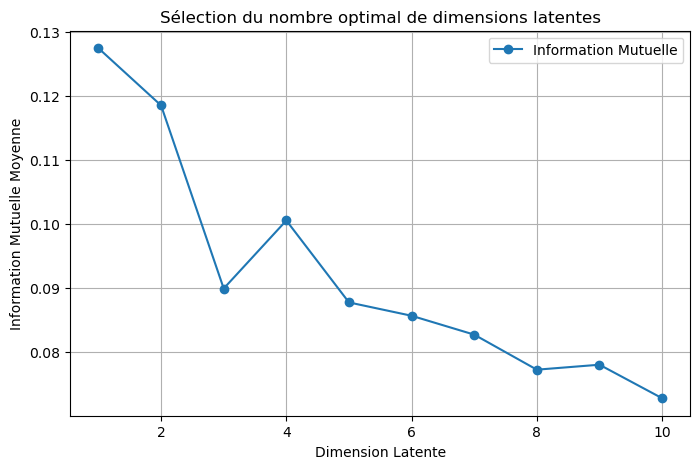

In [14]:
import numpy as np
import tensorflow as tf
import random
import pandas as pd
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt
import os

# === 1. Fixer les graines pour la reproductibilité ===
seed_value = 123
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# === 2. Préparation des données ===
numerical_cols = base_AE.select_dtypes(include=['int', 'float']).columns
categorical_cols = base_AE.select_dtypes(include=['category', 'object']).columns

encoder = OneHotEncoder(sparse_output=False)
encoded_cats = encoder.fit_transform(base_AE[categorical_cols])
encoded_cat_columns = encoder.get_feature_names_out(categorical_cols)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_nums = scaler.fit_transform(base_AE[numerical_cols])

final_data = np.hstack([encoded_cats, scaled_nums])
final_columns = list(encoded_cat_columns) + list(numerical_cols)

x_train, x_test = train_test_split(final_data, test_size=0.3, random_state=seed_value)
input_dim = x_train.shape[1]
initializer = tf.keras.initializers.GlorotUniform(seed=seed_value)

# === 3. Tester différentes dimensions latentes et calculer l'information mutuelle ===
mutual_info_scores = []
latent_dims = range(1, 11)

for encoding_dim in latent_dims:
    input_img = Input(shape=(input_dim,))
    Hidden1 = Dense(350, activation='linear', kernel_initializer=initializer)(input_img)
    encoded = Dense(encoding_dim, activation='linear', kernel_initializer=initializer)(Hidden1)
    Hidden_output1 = Dense(350, activation='sigmoid', kernel_initializer=initializer)(encoded)
    decoded = Dense(input_dim, activation='sigmoid', kernel_initializer=initializer)(Hidden_output1)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    autoencoder.fit(x_train, x_train, epochs=50, batch_size=256, shuffle=True, validation_data=(x_test, x_test), verbose=0)
    
    encoder_model = Model(input_img, encoded)
    encoded_imgs = encoder_model.predict(x_train)
    
    mi_scores = np.array([
        np.mean([mutual_info_regression(x_train[:, j].reshape(-1, 1), encoded_imgs[:, i]) 
                 for j in range(x_train.shape[1])])
        for i in range(encoding_dim)
    ])
    
    mutual_info_scores.append(np.mean(mi_scores))

# === 4. Tracer la courbe de l'information mutuelle ===
plt.figure(figsize=(8, 5))
plt.plot(latent_dims, mutual_info_scores, marker='o', linestyle='-', label="Information Mutuelle")
plt.xlabel("Dimension Latente")
plt.ylabel("Information Mutuelle Moyenne")
plt.title("Sélection du nombre optimal de dimensions latentes")
plt.legend()
plt.grid()
plt.show()


L’analyse de la courbe obtenue montre une tendance générale décroissante de l’information mutuelle lorsque le nombre de dimensions latentes augmente. Cela est attendu, car en réduisant la dimensionnalité, nous éliminons progressivement certaines redondances mais aussi, potentiellement, des informations pertinentes.

Cependant, une observation plus fine révèle que :

* Entre 1 et 5 dimensions, l’information mutuelle diminue de manière marquée mais non linéaire.
* À partir de 5 dimensions, la décroissance devient plus progressive et régulière.
* L’ajout de dimensions au-delà de 5 n’apporte qu’un gain marginal en information mutuelle, suggérant que l’information restante est soit moins pertinente, soit redondante.

Nous choissons donc la valeur 5 pour la dimension de l'espace latent. 

Ce choix garantit un équilibre optimal entre compression et préservation d’information, permettant ainsi d’assurer une représentation efficace et compacte des données tout en évitant des dimensions inutiles.

L’étape suivante consiste à valider ce choix à l’aide de l’erreur de reconstruction, pour s’assurer que l’information capturée par ces 5 dimensions latentes est suffisante pour une bonne qualité de reconstruction des données originales.

Epoch 1/50
83/83 [==============================] - 3s 24ms/step - loss: 0.0595 - val_loss: 0.0401
Epoch 2/50
83/83 [==============================] - 2s 19ms/step - loss: 0.0405 - val_loss: 0.0389
Epoch 3/50
83/83 [==============================] - 1s 17ms/step - loss: 0.0390 - val_loss: 0.0369
Epoch 4/50
83/83 [==============================] - 1s 15ms/step - loss: 0.0374 - val_loss: 0.0359
Epoch 5/50
83/83 [==============================] - 1s 15ms/step - loss: 0.0366 - val_loss: 0.0353
Epoch 6/50
83/83 [==============================] - 2s 20ms/step - loss: 0.0361 - val_loss: 0.0349
Epoch 7/50
83/83 [==============================] - 1s 16ms/step - loss: 0.0358 - val_loss: 0.0347
Epoch 8/50
83/83 [==============================] - 1s 14ms/step - loss: 0.0355 - val_loss: 0.0346
Epoch 9/50
83/83 [==============================] - 1s 14ms/step - loss: 0.0354 - val_loss: 0.0343
Epoch 10/50
83/83 [==============================] - 1s 13ms/step - loss: 0.0351 - val_loss: 0.0342
Epoch 11/

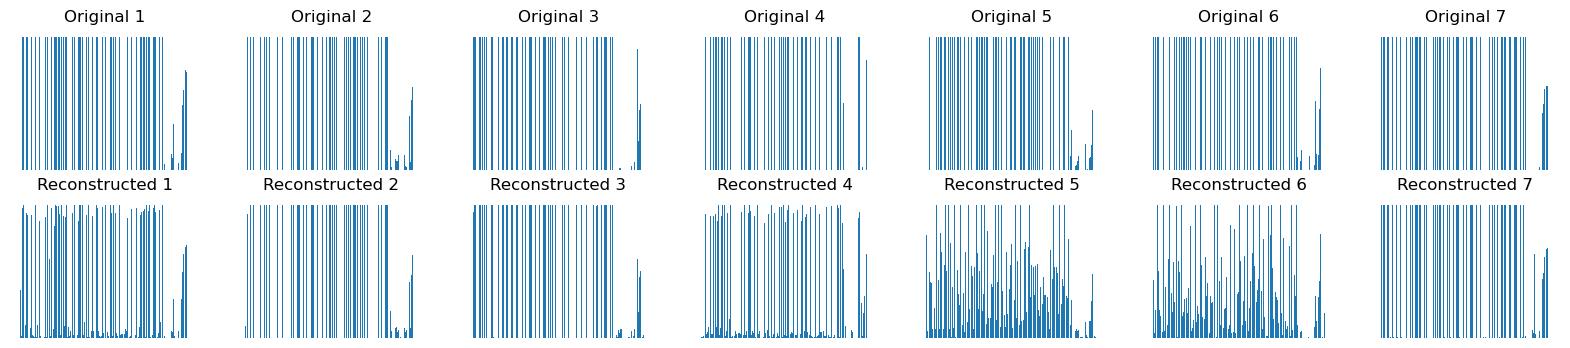

Erreur moyenne de reconstruction : 0.0328


In [ ]:
import numpy as np
import tensorflow as tf
import random
import pandas as pd
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import matplotlib.pyplot as plt
import os

# === 1. Fixer les graines pour la reproductibilité ===
seed_value = 123
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# === 2. Préparation des données ===
# Récupérer les colonnes numériques et catégoriques
numerical_cols = base_AE.select_dtypes(include=['int', 'float']).columns
categorical_cols = base_AE.select_dtypes(include=['category', 'object']).columns

# Encodage des variables catégoriques avec OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
encoded_cats = encoder.fit_transform(base_AE[categorical_cols])

# Récupérer les noms des colonnes générées par OneHotEncoder
encoded_cat_columns = encoder.get_feature_names_out(categorical_cols)

# Centrage et réduction des variables numériques
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_nums = scaler.fit_transform(base_AE[numerical_cols])

# Fusionner les données encodées et normalisées
final_data = np.hstack([encoded_cats, scaled_nums])

# Concaténer les noms des colonnes finales
final_columns = list(encoded_cat_columns) + list(numerical_cols)

# Diviser les données en ensembles d'entraînement et de test
x_train, x_test = train_test_split(final_data, test_size=0.3, random_state=seed_value)

# Dimensions de l'entrée
#input_dim = x_train.shape[1]

# === 2. Définition de l'autoencodeur ===
input_dim = x_train.shape[1]  # Assurez-vous que x_train est bien défini
encoding_dim = 5

# Initialisation déterministe des poids
initializer = tf.keras.initializers.GlorotUniform(seed=seed_value)

# Encodeur
Hidden1 = Dense(350, activation='linear', kernel_initializer=initializer)(input_img)
#Hidden2 = Dense(128, activation='relu', kernel_initializer=initializer)(Hidden1)
#Hidden3 = Dense(64, activation='relu', kernel_initializer=initializer)(Hidden2)
encoded = Dense(encoding_dim, activation='linear', kernel_initializer=initializer)(Hidden1)

# Décodeur
Hidden_output1 = Dense(350, activation='sigmoid', kernel_initializer=initializer)(encoded)
#Hidden_output2 = Dense(128, activation='relu', kernel_initializer=initializer)(Hidden_output1)
#Hidden_output3 = Dense(256, activation='relu', kernel_initializer=initializer)(Hidden_output2)
decoded = Dense(input_dim, activation='sigmoid', kernel_initializer=initializer)(Hidden_output1)#Plus touche

# Modèle autoencodeur
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Entraînement du modèle
history = autoencoder.fit(x_train, x_train,
                          epochs=50,
                          batch_size=256,
                          shuffle=True,
                          validation_data=(x_test, x_test),
                          verbose=1)

# Modèle de l'encodeur seul
encoder = Model(input_img, encoded)

# Représentations encodées (latent space)
encoded_imgs = encoder.predict(x_test)
decoded_imgs = autoencoder.predict(x_test)

# === 4. Visualisation des performances ===
n = 7
plt.figure(figsize=(20, 4))

for i in range(n):
    # Données originales
    ax = plt.subplot(2, n, i + 1)
    plt.bar(range(len(x_test[i])), x_test[i])
    plt.title(f"Original {i+1}")
    plt.axis('off')

    # Reconstructions
    ax = plt.subplot(2, n, i + 1 + n)
    plt.bar(range(len(decoded_imgs[i])), decoded_imgs[i])
    plt.title(f"Reconstructed {i+1}")
    plt.axis('off')

plt.show()

# Analyse des erreurs de reconstruction
reconstruction_error = np.mean((x_test - decoded_imgs) ** 2, axis=1)
print(f"Erreur moyenne de reconstruction : {np.mean(reconstruction_error):.4f}")


Nous obtenons une erreur de reconstruction égale à 0.0328. Ce qui indique que l'autoencodeur parvient à reconstruire les données d'origine avec une précision raisonnable. Nous maintenons donc 5 comme dimension de l'espace latent. 

Aussi Le graphique précédent fait une comparaison entre les 7 premières données originales et leurs versions reconstruites (pour une dimension k=5 de l'espace latent). Et la ressemblence obervée est très forte. Cela témoigne du fait que la valeur k=5 de l'hyperparamètre suffit à capturer efficacement la structure initiale de nos données. 

Nous allons maintenant passer à l'interprétation des nos 5 variables latentes. Mais pour le faire il nous faut savoir quelles variables d'origines ont plus d'influence sur chacun des variables latentes. Pour capturer cette information, nous utiliserons la méthode GradiantExplainer de la bibliothèque shap qui nous donnera une approximation de l'effet d'une pertubation élémentaire de chacune des variables d'origine suer chacune des variables latentes. Ce effet sera utiliser pour déterminer quelles variables de départ influencent le plus quelle variable latente 

In [ ]:
import shap

# === 2. SHAP pour l'analyse des variables d'origine ===
# Adaptation du modèle pour SHAP ===
# Le modèle doit inclure les couches d'entrée jusqu'à l'encodage
#explainer = shap.DeepExplainer(encoder, x_train)  # Sous-échantillon de référence
explainer = shap.GradientExplainer(encoder, x_train)
# === 2. Récupérer les valeurs SHAP pour les données de test ===
shap_values = explainer.shap_values(x_test)  # Analyser un sous-échantillon de test

In [ ]:
# # Vérification de la structure des valeurs SHAP
# print(f"Shape of shap_values: {len(shap_values)} dimensions latentes.")
# print(f"Shape of shap_values for first latent variable: {shap_values[0].shape}")
# print(f"Shape of x_test: {x_test.shape}")
# print(np.shape(shap_values))

In [ ]:
import pandas as pd

# Pour chaque dimension latente
for i in range(5):  # 10 dimensions latentes
    shap_val = shap_values[:, :, i]  # Valeurs SHAP pour la i-ème dimension latente (9000, 724)
    
    # Créer un DataFrame des valeurs SHAP pour les variables d'origine
    shap_df = pd.DataFrame(shap_val, columns=final_columns)  # Colonnes correspondant aux variables d'origine
    
    # Calcul de l'importance moyenne de chaque variable d'entrée pour cette dimension latente
    mean_shap_values = shap_df.abs().mean().sort_values(ascending=False)  # Moyenne des valeurs absolues
    print(f"Les variables les plus influentes pour la {i+1}-ème dimension latente:")
    print(mean_shap_values.head(10))  # Afficher les 5 variables les plus influentes pour la dimension latente i+1


Les variables les plus influentes pour la 1-ème dimension latente:
is_first_exam_success_1                              4.033124
is_first_exam_success_2                              2.977121
pct_no_objective_weeks                               2.670113
pct_study_objective_not_reached                      2.494268
choice_01_b6a4bca6-eb45-46b6-be09-06c4f22a1d9f_1     2.286206
choice_00_b6a4bca6-eb45-46b6-be09-06c4f22a1d9f_1     2.266252
prendre_quitter_vehicule_number_of_activities        1.855797
has_passed_theory_exam_1                             1.825285
autres_usagers_number_of_activities                  1.779124
is_correct_b6a4bca6-eb45-46b6-be09-06c4f22a1d9f_1    1.730351
dtype: float64
Les variables les plus influentes pour la 2-ème dimension latente:
choice_02_d793123e-7c12-47de-8352-5eeefc6b088e_0     3.502550
is_correct_d793123e-7c12-47de-8352-5eeefc6b088e_0    3.447411
choice_03_d793123e-7c12-47de-8352-5eeefc6b088e_0     3.391110
is_first_exam_success_1                      

La sortie précédente donne pour chacune des variables de la dimension latente les variables d'origine les plus influentes. Mais cette sortie serait plus intéressante sous forme de graphique.

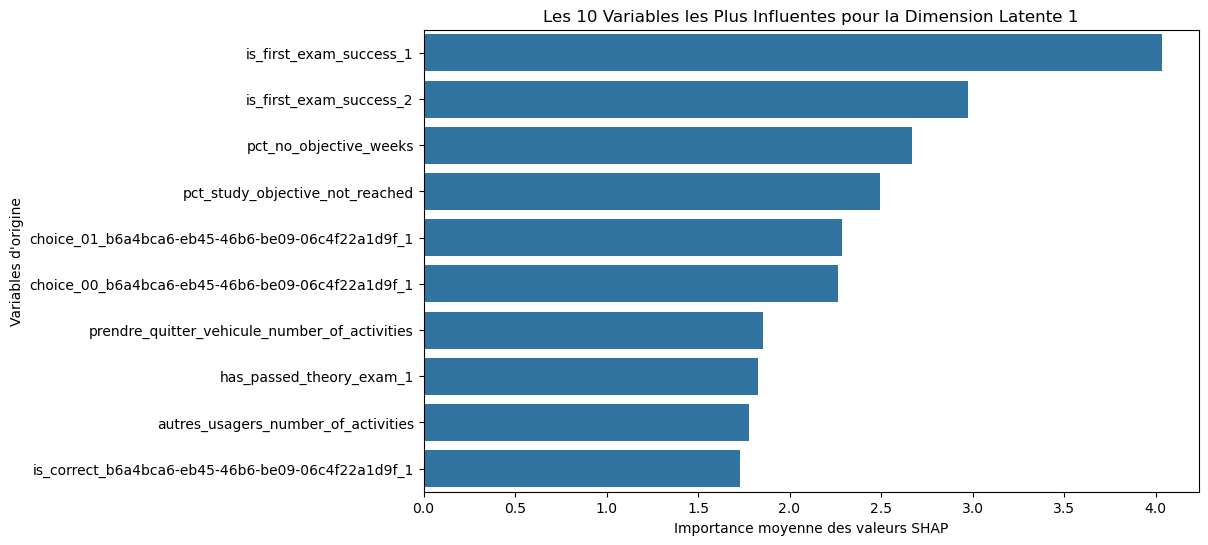

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pour chaque dimension latente
i=0 # dimensions latentes
shap_val = shap_values[:, :, i]  # Valeurs SHAP pour la i-ème dimension latente (9000, 724)
    
# Créer un DataFrame des valeurs SHAP pour les variables d'origine
shap_df = pd.DataFrame(shap_val, columns=final_columns)  # Colonnes correspondant aux variables d'origine
    
# Calcul de l'importance moyenne de chaque variable d'entrée pour cette dimension latente
mean_shap_values = shap_df.abs().mean().sort_values(ascending=False)  # Moyenne des valeurs absolues
    
# Affichage des 5 variables les plus influentes sous forme de barplot horizontal
plt.figure(figsize=(10, 6))
sns.barplot(x=mean_shap_values.head(10).values, y=mean_shap_values.head(10).index, orient='h')  # Orienté horizontalement
plt.title(f"Les 10 Variables les Plus Influentes pour la Dimension Latente {i+1}")
plt.xlabel("Importance moyenne des valeurs SHAP")
plt.ylabel("Variables d'origine")
plt.show()


Cette dimension reflète la **préparation du candidat** et ses **performances initiales** dans le cadre de l'examen de permis. Les variables clés sont :

* **Réussite au premier examen** (is_first_exam_success_1, is_first_exam_success_2) : Indique si le candidat a réussi son premier examen.  
* **Manque d'objectifs d’étude** (pct_no_objective_weeks) : Montre si le candidat n'a pas d'objectifs clairs pendant sa préparation.  
* **Objectifs d’étude non atteints** (pct_study_objective_not_reached) : Mesure les objectifs d’étude non réalisés.  
* **Réponses aux questions d'examen** (choice_01_..., choice_00_...) : Indique les réponses correctes ou incorrectes aux questions.  
* **Activités pratiques de conduite** (prendre_quitter_vehicule_number_of_activities) : Nombre d'activités pratiques réalisées.  
* **Réussite à l'examen théorique** (has_passed_theory_exam_1) : Indique si le candidat a réussi l'examen théorique.  
* **Interactions avec d'autres usagers** (autres_usagers_number_of_activities) : Mesure l'expérience avec d'autres conducteurs.

La dimension évalue **la préparation et la réussite initiale** du candidat, en tenant compte de ses performances théoriques et pratiques, ainsi que de son engagement dans la préparation.


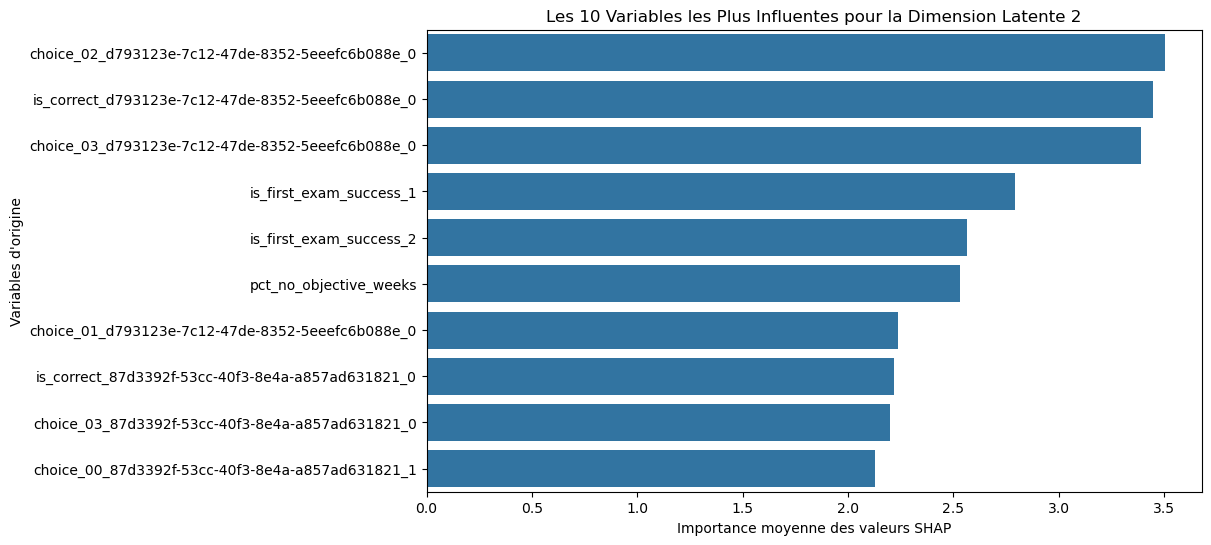

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pour chaque dimension latente
i=1 # dimensions latentes
shap_val = shap_values[:, :, i]  # Valeurs SHAP pour la i-ème dimension latente (9000, 724)
    
# Créer un DataFrame des valeurs SHAP pour les variables d'origine
shap_df = pd.DataFrame(shap_val, columns=final_columns)  # Colonnes correspondant aux variables d'origine
    
# Calcul de l'importance moyenne de chaque variable d'entrée pour cette dimension latente
mean_shap_values = shap_df.abs().mean().sort_values(ascending=False)  # Moyenne des valeurs absolues
    
# Affichage des 5 variables les plus influentes sous forme de barplot horizontal
plt.figure(figsize=(10, 6))
sns.barplot(x=mean_shap_values.head(10).values, y=mean_shap_values.head(10).index, orient='h')  # Orienté horizontalement
plt.title(f"Les 10 Variables les Plus Influentes pour la Dimension Latente {i+1}")
plt.xlabel("Importance moyenne des valeurs SHAP")
plt.ylabel("Variables d'origine")
plt.show()


Cette dimension semble évaluer la **compréhension théorique** du candidat ainsi que sa **réaction aux questions spécifiques** du test. Les variables les plus influentes sont :

* **Réponses incorrectes aux questions spécifiques** (choice_02_..., choice_03_...) : Ces variables montrent les mauvaises réponses données aux questions du test. Cela reflète des **difficultés théoriques** ou un manque de préparation pour certains types de questions.
* **Exactitude des réponses spécifiques** (is_correct_...) : Indique si les réponses aux questions spécifiques étaient correctes ou non, ce qui montre l’**exactitude** du candidat dans la compréhension théorique.
* **Réussite au premier examen** (is_first_exam_success_1, is_first_exam_success_2) : Bien que déjà mentionnée, ici elle peut refléter la **compréhension théorique** du candidat, surtout par rapport à des erreurs spécifiques.


La **dimension latente 2** se concentre sur la **performance théorique** du candidat, en mettant en lumière ses **réponses correctes ou incorrectes** aux questions spécifiques du test et ses erreurs fréquentes, ce qui donne un aperçu de ses **difficultés théoriques**.


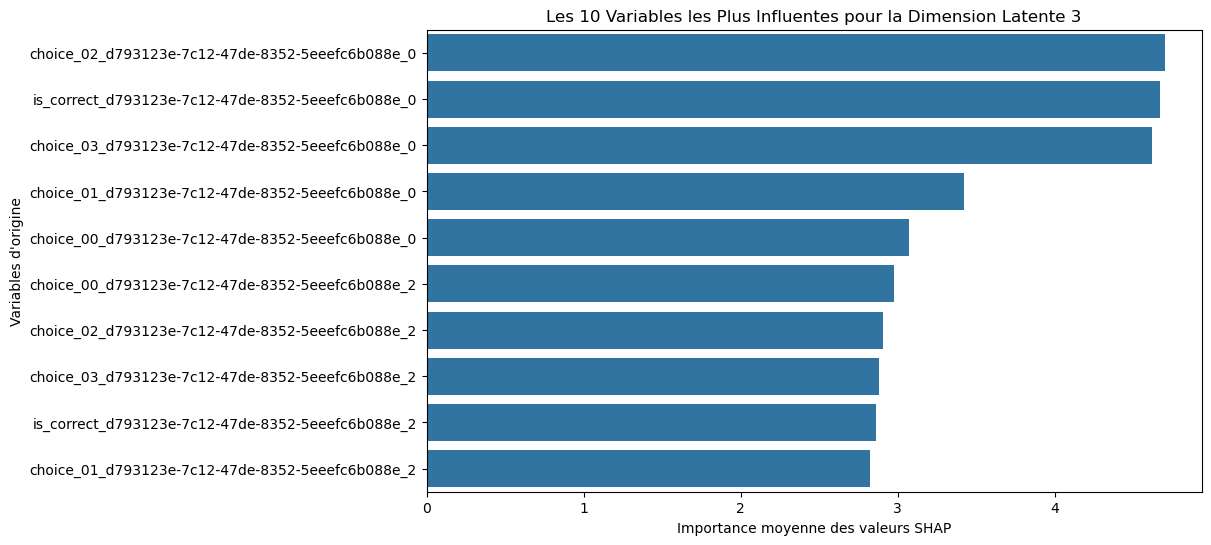

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pour chaque dimension latente
i=2 # dimensions latentes
shap_val = shap_values[:, :, i]  # Valeurs SHAP pour la i-ème dimension latente (9000, 724)
    
# Créer un DataFrame des valeurs SHAP pour les variables d'origine
shap_df = pd.DataFrame(shap_val, columns=final_columns)  # Colonnes correspondant aux variables d'origine
    
# Calcul de l'importance moyenne de chaque variable d'entrée pour cette dimension latente
mean_shap_values = shap_df.abs().mean().sort_values(ascending=False)  # Moyenne des valeurs absolues
    
# Affichage des 5 variables les plus influentes sous forme de barplot horizontal
plt.figure(figsize=(10, 6))
sns.barplot(x=mean_shap_values.head(10).values, y=mean_shap_values.head(10).index, orient='h')  # Orienté horizontalement
plt.title(f"Les 10 Variables les Plus Influentes pour la Dimension Latente {i+1}")
plt.xlabel("Importance moyenne des valeurs SHAP")
plt.ylabel("Variables d'origine")
plt.show()


Cette dimension semble capturer la **sensibilité du candidat aux questions difficiles ou pièges** dans l'examen théorique.  Les variables clés sont :   
1. **Échecs aux mêmes questions spécifiques** (choice_02_..., choice_03_..., choice_01_..., is_correct_...) : Indique que certaines questions reviennent souvent parmi les erreurs du candidat.  
2. **Présence d’options "Non Renseigné"** (choice_00_..._2, choice_02_..._2, etc.) : Le candidat n’a peut-être pas répondu ou a hésité, suggérant une **incertitude face aux questions complexes**.  

La **dimension latente 3** reflète la **difficulté du candidat avec les questions théoriques complexes**, particulièrement celles qui induisent en erreur ou demandent une compréhension plus fine des règles. Cela peut indiquer un manque de confiance ou une hésitation face aux pièges du test.  


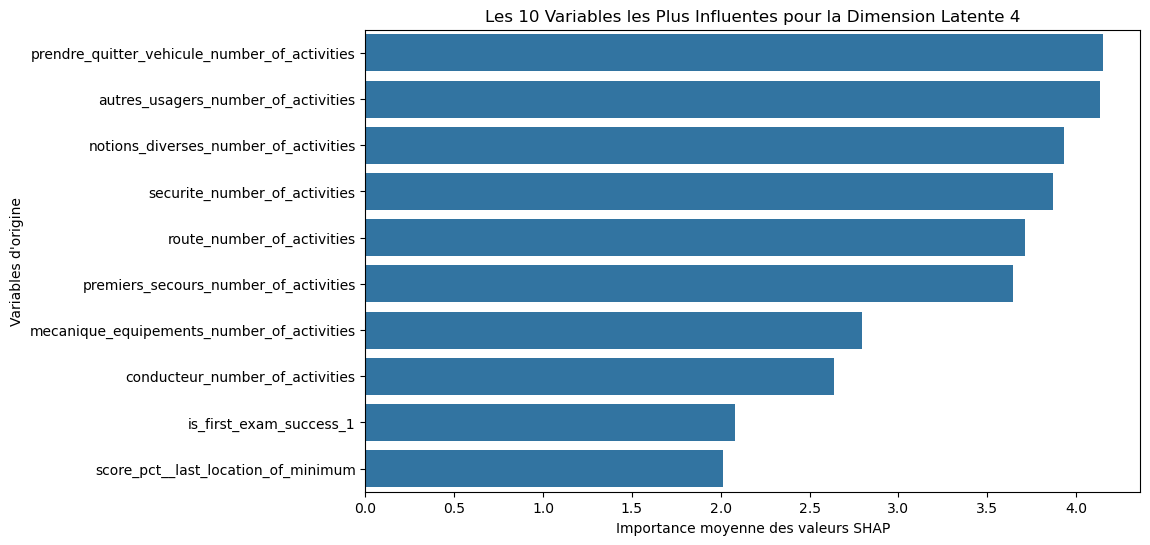

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pour chaque dimension latente
i=3 # dimensions latentes
shap_val = shap_values[:, :, i]  # Valeurs SHAP pour la i-ème dimension latente (9000, 724)
    
# Créer un DataFrame des valeurs SHAP pour les variables d'origine
shap_df = pd.DataFrame(shap_val, columns=final_columns)  # Colonnes correspondant aux variables d'origine
    
# Calcul de l'importance moyenne de chaque variable d'entrée pour cette dimension latente
mean_shap_values = shap_df.abs().mean().sort_values(ascending=False)  # Moyenne des valeurs absolues
    
# Affichage des 5 variables les plus influentes sous forme de barplot horizontal
plt.figure(figsize=(10, 6))
sns.barplot(x=mean_shap_values.head(10).values, y=mean_shap_values.head(10).index, orient='h')  # Orienté horizontalement
plt.title(f"Les 10 Variables les Plus Influentes pour la Dimension Latente {i+1}")
plt.xlabel("Importance moyenne des valeurs SHAP")
plt.ylabel("Variables d'origine")
plt.show()



Cette dimension semble refléter **l'implication du candidat dans les différentes catégories d’exercices pratiques**.  Les variables clés sont :  
1. **Nombre d’activités réalisées** (prendre_quitter_vehicule_number_of_activities, route_number_of_activities, securite_number_of_activities, etc.) : Indique le volume d’exercices effectués dans différents domaines.  
2. **Thèmes couverts** (mécanique, premiers secours, autres usagers, etc.) :  Montre si le candidat a exploré plusieurs aspects du code et de la conduite.  
3. **Succès au premier examen théorique** (is_first_exam_success_1) :  Une corrélation avec la réussite suggère que l'engagement pratique peut influencer les performances théoriques.  

La **dimension latente 4** représente **l’implication du candidat dans la formation pratique** et sa diversité d’exercices. Un score élevé ici pourrait indiquer un candidat **sérieux et appliqué** dans son apprentissage.  


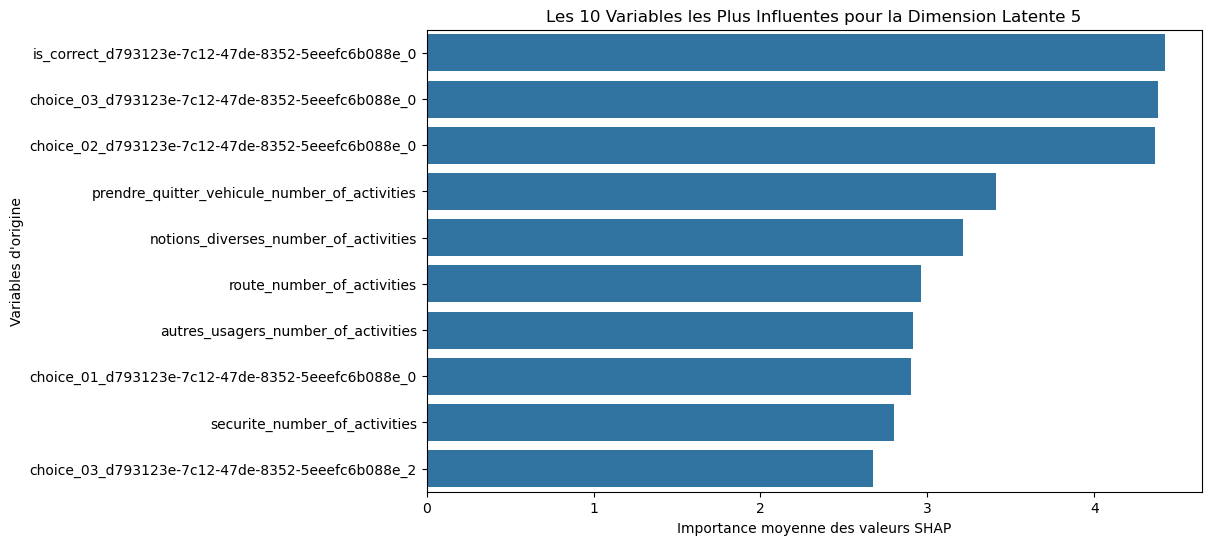

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pour chaque dimension latente
i=4 # dimensions latentes
shap_val = shap_values[:, :, i]  # Valeurs SHAP pour la i-ème dimension latente (9000, 724)
    
# Créer un DataFrame des valeurs SHAP pour les variables d'origine
shap_df = pd.DataFrame(shap_val, columns=final_columns)  # Colonnes correspondant aux variables d'origine
    
# Calcul de l'importance moyenne de chaque variable d'entrée pour cette dimension latente
mean_shap_values = shap_df.abs().mean().sort_values(ascending=False)  # Moyenne des valeurs absolues
    
# Affichage des 5 variables les plus influentes sous forme de barplot horizontal
plt.figure(figsize=(10, 6))
sns.barplot(x=mean_shap_values.head(10).values, y=mean_shap_values.head(10).index, orient='h')  # Orienté horizontalement
plt.title(f"Les 10 Variables les Plus Influentes pour la Dimension Latente {i+1}")
plt.xlabel("Importance moyenne des valeurs SHAP")
plt.ylabel("Variables d'origine")
plt.show()


Cette dimension semble réfléter la **Performance sur des Questions Spécifiques et Expérience Pratique**  

Les variables clés sont :  
1. **Réponses correctes sur des questions spécifiques** (is_correct_d793123e…, choice_03…, choice_02…) :  Indique si le candidat a bien répondu à certaines questions du test.  
2. **Nombre d’activités pratiques** (prendre_quitter_vehicule_number_of_activities, notions_diverses_number_of_activities, route_number_of_activities, etc.) :  Reflète l'expérience accumulée dans différents aspects de la conduite.  

Cette **dimension latente 5** semble capturer **la capacité à répondre correctement à des questions ciblées tout en ayant une certaine expérience pratique**. Un score élevé peut refléter un candidat **qui combine théorie et application**.  



## Conception de l'autoencodeur sur les variables continues

In [1]:
import numpy as np
import tensorflow as tf
import random
import pandas as pd
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import matplotlib.pyplot as plt
import os

# === 1. Fixer les graines pour la reproductibilité ===
seed_value = 123
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# === 2. Préparation des données ===
# Récupérer uniquement les colonnes numériques 
numerical_cols = base_AE.select_dtypes(include=['int', 'float']).columns


# Centrage et réduction des variables numériques
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_nums = scaler.fit_transform(base_AE[numerical_cols])

# Fusionner les données encodées et normalisées
final_data = np.hstack([scaled_nums])

# Concaténer les noms des colonnes finales
final_columns = list(numerical_cols)

# Diviser les données en ensembles d'entraînement et de test
x_train_1, x_test_1 = train_test_split(final_data, test_size=0.3, random_state=seed_value)

# Dimensions de l'entrée
input_dim = x_train_1.shape[1]

# === 3. Entraînement des autoencodeurs pour différentes dimensions latentes ===
results = []

for encoding_dim in range(1, 21):  # Tester des dimensions latentes de 1 à 20
    # Initialisation déterministe des poids
    initializer = tf.keras.initializers.GlorotUniform(seed=seed_value)

    # Construction de l'autoencodeur
    input_img = Input(shape=(input_dim,))
    # Encodeur
    Hidden1_1 = Dense(150, activation='linear', kernel_initializer=initializer)(input_img)
    #Hidden2 = Dense(100, activation='linear', kernel_initializer=initializer)(Hidden1)
    #Hidden3 = Dense(64, activation='relu', kernel_initializer=initializer)(Hidden2)
    encoded_1 = Dense(encoding_dim, activation='linear', kernel_initializer=initializer)(Hidden1)

    # Décodeur
    Hidden_output1_1 = Dense(150, activation='sigmoid', kernel_initializer=initializer)(encoded)
    #Hidden_output2 = Dense(100, activation='sigmoid', kernel_initializer=initializer)(Hidden_output1)
    #Hidden_output3 = Dense(350, activation='sigmoid', kernel_initializer=initializer)(Hidden_output2)
    decoded_1 = Dense(input_dim, activation='sigmoid', kernel_initializer=initializer)(Hidden_output1)#Plus touche


    # Créer le modèle
    autoencoder_1 = Model(input_img, decoded_1)

    # Compiler le modèle
    autoencoder_1.compile(optimizer='adam', loss='mse')

    # Entraîner le modèle
    history = autoencoder_1.fit(
        x_train_1, x_train_1,
        epochs=50,
        batch_size=256,
        shuffle=True,
        validation_data=(x_test_1, x_test_1),
        verbose=0
    )

    # Récupérer la perte de validation à la dernière époque
    final_loss = history.history['val_loss'][-1]

    # Ajouter la dimension et la perte au tableau des résultats
    results.append({'encoding_dim': encoding_dim, 'loss': final_loss})

# === 4. Visualisation des résultats ===
df_results = pd.DataFrame(results)
print(df_results)

# plt.figure(figsize=(8, 5))
# plt.plot(df_results['encoding_dim'], df_results['loss'], marker='o', linestyle='-', color='b', label='Perte (Loss)')
# plt.xlabel('Dimension Latente (encoding_dim)', fontsize=12)
# plt.ylabel('Erreur (Loss)', fontsize=12)
# plt.title('Courbe des erreurs en fonction de la dimension latente', fontsize=14)
# plt.grid(True, linestyle='--', alpha=0.6)
# plt.xticks(df_results['encoding_dim'])
# plt.legend(fontsize=12)
# plt.show()


NameError: name 'base_AE' is not defined